# Markov Chain Monte Carlo and Applications

v1.0 (2018 Spring) Tavor Baharav, Kaylee Burns, Gary Cheng, Sinho Chewi, Hemang Jangle, William Gan, Alvin Kao, Chen Meng, Vrettos Muolos, Kanaad Parvate, Ray Ramamurti, Kannan Ramchandran

v1.1 (2019 Fall) William Gan, Justin Hong, Raghav Anand, Alex Li, Katie Kang, Eric Liu, Aditya Mishra, Kevin Lu, Michael Whitmeyer, Sean Meng, Alan He, Nikita Dhawan, Tae Hyung Kim, Shyam Parekh

v1.2 (2022 Fall) Tweaks by Axel Li

v1.3 (2023 Spring) Tweaks by Reina Wang

## Introduction

Markov Chain Monte Carlo methods are a powerful collection of techniques that allow us to sample from a distribution _even if we can't calculate the distribution directly._ This is useful for complex models, whose distributions may be intractable to compute. The idea is that, if we are able to sample from our desired distribution, we can answer any questions we may have about that distribution.

## What is MCMC?

Our goal is to simulate a Markov chain with a state for each outcome in our probability space. If the stationary distribution of the chain matches the distribution we want to sample from, then a random walk on the chain should perform like a sequence of samples from our desired distribution.

In this lab we will be focusing on the Metropolis-Hastings algorithm, but this is not the only kind of MCMC method. Gibbs sampling, which you may have encountered in CS 188, is also a MCMC method. Gibbs sampling, however, requires computing a conditional distribution for each random variable in your model, which can be impractical and inefficient for some problems.

We'll also explore an application of our algorithm to a sneaky spy challenge: use Metropolis-Hastings to decode the secret messages Gary is sending to Tavor! 🕵️

## Developing Metropolis Hastings (MH)

Our task is to define a set of transition and acceptance probabilities so that we have an aperiodic Markov Chain whose stationary distribution $\pi(x)$ is equal to our target distribution $P(x)$. The MH algorithm does this implicitly by defining a procedure for transitioning between states. However, it has some assumptions. In particular, it assumes that you can compute:

- $f(x)$, **a directly proportional estimate** of $P(x)$, i.e. $P(x) = \frac{f(x)}{\sum_{y \in \mathcal{X}} f(y)}$.
- $g(x, \cdot)$, a proposal distribution for the next state, where $x$ is your current state.

The MH algorithm says, at each time step:

- Propose the next candidate state $y$ according $g(x,\cdot)$.
- Accept $y$, with probability $A(x,y) = min\{1, \frac{f(y)g(y,x)}{f(x)g(x,y)}\}$.
- If you accept the proposal, transition to $y$. Otherwise, stay in $x$.

Following this procedure, the stationary distribution of the implicitly defined Markov Chain will be $P(x)$. Thus you can take a random walk to sample from $P(x)$. However, in practice, the following two extensions are made:

- Taking every step-th state in the random walk. This helps reduce the dependence between samples.
- Letting the chain walk a bit so that the distribution can converge to the stationary distribution.

In [1]:
# a bit of setup
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
import utils

from super_sneaky_secret import the_secret_message

## Implementation

In the cell below, implement Metropolis-Hastings according to the doc string. It should work for generic proposal, acceptance, and intitialization functions.

In [2]:
def metropolis_hastings(proposal_func, init_func, score_func,
                        num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate candidate states and scorer to
    assign probability scores to candidate
    states.
    
    proposal_func: function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func: function that proposes starting
        state; takes no arguments and returns a
        sample state
    score_func: function that calculates f(y)/f(x)
        * g(y,x)/g(x,y); takes in two state samples
        (the current sample x then the candidate y).
    
    Returns a sequence of every step-th sample. You 
    should sample regardless of whether a transition 
    occurs. The length of the final sequence should 
    be num_iters // step.
    """
    # TODO
    samples = []
    sample = init_func()
    for i in range(num_iters):
        candidate = proposal_func(sample)
        acceptance_prob = min(1, score_func(sample, candidate))
        if np.random.uniform() < acceptance_prob:
            sample = candidate
        samples.append(sample)
    return samples[::step]

## Sampling from Distributions Using MH

Now that we have a method for sampling from distributions, let's apply it to some models. We'll start with very simple models so that we can compare the results from sampling with what we can compute analytically. This is also a useful opportunity for you to debug your implementation. Your implementation should be able to model a Gaussian and exponential distribution successfully.

*Note: Our proposal distribution will be a normal distribution centered around our current state for the purposes of this lab. Take this into account when analyzing these examples.*

*An interesting fact to note is that the algorithm works even for these **continuous distributions**. In this case the underlying Markov Chain will have a continuous state space ($\mathbb{R}$)*

## A Friendly Gaussian: $\mathcal{N}(60, 1)$

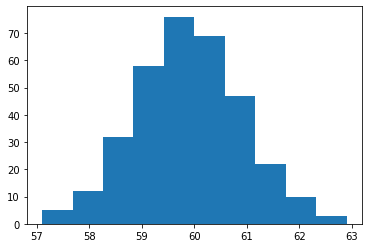

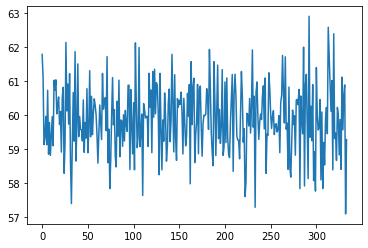

In [3]:
sample_prior = lambda: np.random.normal(loc=60)
sample_candidate = lambda theta: np.random.normal(loc=theta)
scorer = lambda x, y: (math.exp(-((y - 60)**2)/2)) / (math.exp(-((x - 60)**2)/2))
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 10000)
utils.plot_histogram_and_transitions(normal_samples)

## Exponential Distribution: $\mathcal{Exp}(.5)$

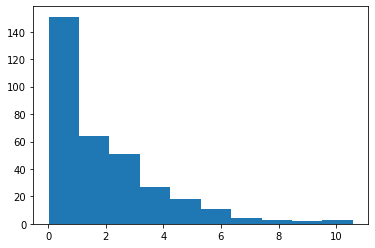

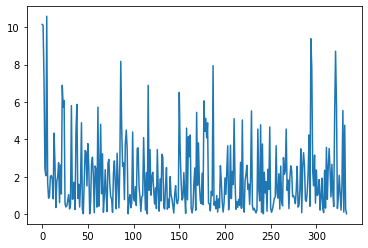

In [4]:
exp_pdf = utils.exp(0.5)
exp_scorer = lambda x,y: exp_pdf(y) / exp_pdf(x)
exp_prior = lambda : 10
exp_samples = metropolis_hastings(sample_candidate, exp_prior, exp_scorer, 10000)
utils.plot_histogram_and_transitions(exp_samples)

## Effects of Initial Distribution, Convergence Diagnosis and Burn-in Time
In the case of the Gaussian above, our `init_function`(initial distribution) was $\mathcal{N}(60,1)$ which is exactly the same as the distribution we were trying to sample, i.e, we started the chain from the stationary distribution. However in general, we obviously don't have the ability to sample from the distribution we were trying to sample from in the first place! Notice that in the exponential, it goes down drastically from 10 where we started the chain, and oscillates more around lower values.

Now run the following code, and answer the questions below.

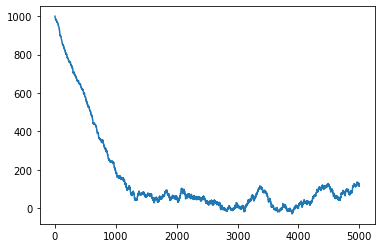

In [5]:
sample_prior = lambda: np.random.normal(loc=1000)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=3)
normal_pdf = utils.normal(60,30)
scorer = lambda x, y: normal_pdf(y) / normal_pdf(x)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
utils.plot_transitions(normal_samples)

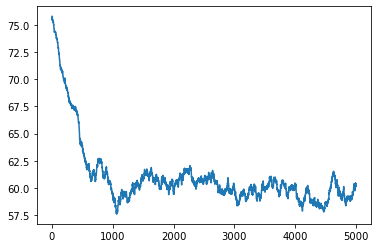

In [6]:
sample_prior = lambda: np.random.normal(loc=75)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=0.1)
normal_pdf = utils.normal(60,1)
scorer = lambda x, y: normal_pdf(y) / normal_pdf(x)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
utils.plot_transitions(normal_samples)

Are there some samples we need to ignore at the beginning? Explain what is happening with the Markov Chain based on the parameters we've used and your observations from the state vs iteration plot and tell us approximately how many samples we need to ignore.

### *YOUR ANSWER HERE*

*In the algorithm, the underlying Markov Chain tries to attain its stationary distribution which by design is the distribution we want to sample from. In the last two experiments we started with an intial distribution that is 'farther' from the stationary distribution (for example in the first case the initial distribution is $\mathcal{N}(1000,1)$ and the distribution we wish to sample is $\mathcal{N}(60,1)$). In the state vs iteration plots, notice that there is a steep drop for approximately the first 1000 iterations. In this period it is has not yet converged to the distribution we want to sample from so we should throw out the first 1000 samples or so. This initial period when the chain is still approaching stationarity is called the burn-in time.*

## Drawbacks of MCMC Techniques

Now we'll evaluate the effectiveness of our sampling technique on a variety of models. The examples below will highlight some of the drawbacks and idiosyncrasies of MCMC techniques. We will look at this in the context of distributions with two peaks (two separated regions of high probability), also known as bimodal distributions. We will see that the peaks may not be sampled appropriately.

## Bimodal Mixture of Gaussians

A mixture of Gaussians is obtained when you have two subpopulations ('classes') each distributed normally($\mathcal{N}(\mu_1,\sigma_1^2)$ and $\mathcal{N}(\mu_2,\sigma_2^2)$) . An example is heights of people with the subclasses of men and women. In the mixture model the 'classes' have probabilities $p$ and $1-p$ respectively. So the pdf of this distribution would be $$p\cdot f_X(x\ |\text{ class 1}) + (1-p)\cdot f_X(x\ |\text{ class 2}) = p\cdot \frac{1}{\sqrt{2\pi \sigma_1^2}} e^{-\frac{(x - \mu_1)^2}{2\sigma_1^2}} + (1-p)\cdot \frac{1}{\sqrt{2\pi \sigma_2^2}} e^{-\frac{(x - \mu_2)^2}{2\sigma_2^2}}
$$

For there to be two peaks in the pdf (to be bimodal), there should be (loosely speaking) sufficient separation between the means with respect to the standard deviations(the widths of the distributions). Otherwise if the peaks are too close relative to the widths, it is possible for the mixture to lead to just one central peak between the two means. There are exact conditions for this you can look up if you are interested. 

For this part we will be using a mixture with equal probabilities $(0.5)$ on each of the individual Gaussians with means $60$ and $40$. Try MH on this distribution for standard deviations of $5,3,1$ for each of the individual Gaussians. You should see that one of the peaks dominates (could be either one) as the standard deviation reduces even though both classes have an equal probability. For low std devs 2 and 1, only one peak should show up. 

In [7]:
def sample_from_bimodal(stdev):
    """Samples from bimodal mixture of Gaussians
    with standard deviation stdev, as described above."""
    
    pdf = utils.gauss_mix(0.5,40,stdev,60,stdev)

    sample_candidate = lambda theta: np.random.normal(loc=theta)
    new_scorer = lambda x,y: pdf(y)/pdf(x) 
    new_prior = lambda : 50

    points = metropolis_hastings(sample_candidate, new_prior, new_scorer, 10000)
    utils.plot_histogram_and_transitions(points)

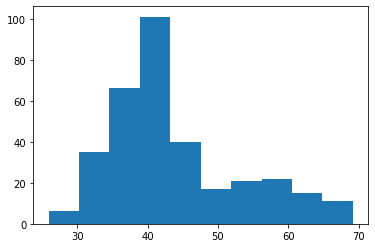

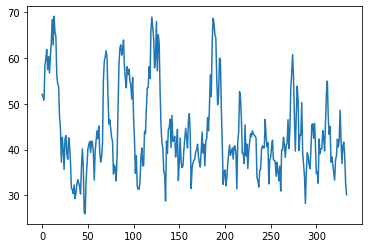

In [8]:
sample_from_bimodal(5)

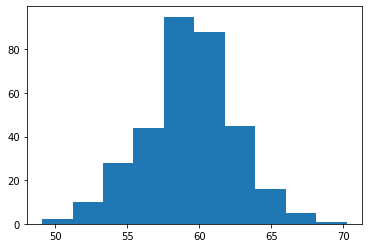

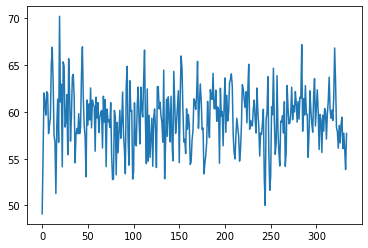

In [9]:
sample_from_bimodal(3)

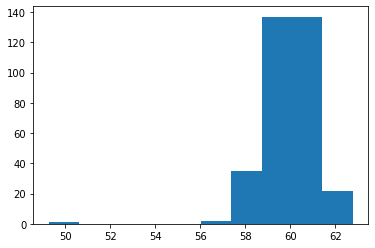

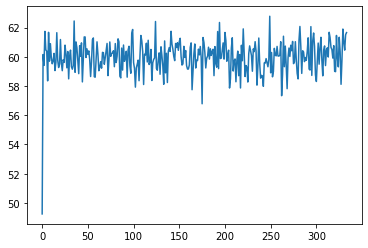

In [10]:
sample_from_bimodal(1)

What effect do you think changing the standard deviation has? What possible disadvantage of MH does this bimodal distribution show?

*Hints:* 
* *There should be jumps in your transition plots (at least for std devs 4 and 5). Think about what these jumps mean.*
* *As the widths of the peaks grow thinner, how often would you propose a state on the other peak that has a high probability?*
* *How many iterations would we need to tell that we've got samples from both classes a reasonable number of times?*

### *YOUR ANSWER HERE* 

*Our distributions in these experiments have two peaks at 40 and 60, so there are jumps in the state vs iteration graphs from oscillations around 60 to oscillations around 40.*

*Since our probability p of picking from either Gaussian was 0.5 in each experiment, we should have seen equally sampled peaks. However we see this only for std devs 5 and maybe 4.*

*When we decrease the standard deviations, each of the two Gaussians gets narrower which means there is more separation between the high probability regions around 40 and 60. This means that once it starts exploring one peak, it is more unlikely for the proposal (or jumping distribution) to propose a value near the other peak with a high enough probability for acceptance as it would have to propose a value further from its current location. In the case where our standard deviation was 5, the std deviation (width of the classes) was large enough for proposals between the peaks to have high enough acceptance probability so that it can jump between the two peaks. As the standard deviation goes down, the transitions stay around one peak for longer and the jumps become rarer.*

*This also illustrates a disadvantage for MH for bimodal distributions. We cannot be sure when it will jump to the other peak which means it is difficult to choose an appropriate number of iterations to sample both peaks evenly. This, as the experiments show, is more pronounced as the peaks get further away w.r.t their standard deviations.*

## Decoding Secret Messages Using MCMC

Now we'll use our algorithm to solve a mystery on the EE 126 staff. Grumpy Gary and Tricky Tavor are sending each other secret messages using a cipher: each character in the message is either an uppercase letter or a space (denoted _ ) (27 possible characters), and their cipher is a one-to-one mapping between the letters of the alphabet + _. To send a message, they replace each character with the corresponding character in their cipher.

For example, if their cipher was the following:

A | B | C | D | E | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | T | U | V | W | X | Y | Z | _

X | T | A | G | M | L | C | Q | P | Z | H | W | J | I | E | B | K | O | _ | F | D | U | L | N | R | S | Y

Then 'HELLO WORLD' would translate to 'QMWWEYLEOWG'. Your job is to decode their message using the Metropolis-Hastings algorithm you wrote above. Our goal is to find the cipher that maximizes the likelihood of seeing the characters in the translated message. The cipher will be a list of integers representing the letter of the alphabet that the letter corresponding to that index should be translated to. For example, if "g" should be replaced with "a", then $\text{cipher}[6]$ should equal 0. **Note: 0-index when counting letters of the alphabet.**

Our model of language will consider each character to be dependent only on the previous character. For example,

$$\mathbb{P}(x_1 = c, x_2 = a, x_3 = t) = \mathbb{P}(x_1 = c)\mathbb{P}(x_2 = a|x_1 = c)\mathbb{P}(x_3 = t|x_2 = a)$$

These transition probabilities will be calculated empirically by counting the number of transitions between every pair of characters in a large corpus of text.

The state space is the set of all ciphers $X = \{\sigma : \sigma \text{ is a permutation of the English alphabet and '  '}\}$. $|X| = 27!$, so finding the most likely cipher is far too costly to calculate naively, but we can sample from the space of all ciphers intelligently by using Metropolis-Hastings with the following functions:

**Proposals**: To propose new ciphers, we will randomly swap two characters in our cipher.

**Acceptance Function**: Note that because our proposal distribution is symmetric, the acceptance probability becomes $A(x,y) = min\{1, \frac{f(y)}{f(x)}\}$. 
$f(x)$ is the probability of observing the sequence of characters in the message decoded by cipher $x$: 

$$f(\cdot) = \mathbb{P}(x_1 = \text{letter}_1)\mathbb{P}(x_2 = \text{letter}_2|x_1 = \text{letter}_1)\mathbb{P}(x_3 = \text{letter}_3|x_2 = \text{letter}_2)$$

$f(\cdot)$ is _not_ a valid probability over all ciphers because we don't normalize, but it is sufficient for us to compare two ciphers.

Here is an example of one iteration of the algorithm. If we are dealing with a reduced alphabet of $\{A,B,C,D,\text{' '}\}$ and our current cipher is $[ 2,0,4,3,1 ]$, then we are mapping $A->C, B->A, C->\text{' '}$, etc. If our proposal function suggests the perturbed cipher $[ 4,0,2,3,1 ]$, we will accept this cipher as our new state with probability $min \{1, \frac{f([ 4,0,2,3,1 ])}{f([ 2,0,4,3,1 ])}\}$.

We wrote functions to find the bigram frequency matrix, which gives the transition probabilities between characters, and to convert messages into a numerical format. To run the starter code below, you will need to run the `download_war_and_peace.sh` script to download corpus from which we will learn the transition probabilities. Run `./download_war_and_peace.sh` from this directory.

Some final notes and tips:
- For simplicity's sake, don't worry about the initial $P(x_1 = \text{letter}_1)$: the sequence is 538 characters long, so this initial probability won't affect the relative probability between 2 ciphers by any noticeable amount.
- To translate from letters to numbers quickly, take a look at the built-in `ord` function. Keep in mind that we are only working with uppercase letters, so it will map each letter to an integer in the range 65 to 90.
- For numerical stability, to find $\frac{f(y)}{f(x)}$, compute $\log(f(y)) - \log(f(x))$, and then pass it to the exp function.

In [11]:
# For Linux/MacOS
!./download_war_and_peace.sh

# On Windows download from https://www.gutenberg.org/files/2600/2600-0.txt
# and save as war_and_peace.txt

zsh:1: permission denied: ./download_war_and_peace.sh


In [13]:
input_file = "war_and_peace.txt"

def build_bigram_freq_matrix(input_file):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([27, 27])
    with open(input_file, 'r', encoding='utf8') as f:
        for _ in range(100000):
            line = f.readline()
            if len(line) > 2:
                for i in range(len(line) - 2):
                    first_char = ord(line[i].upper()) - 65 if line[i].isalpha() else 26
                    second_char = ord(line[i+1].upper()) - 65 if line[i+1].isalpha() else 26
                    if not (first_char == 26 and second_char == 26) and first_char <= 26 and second_char <= 26:
                        counts[first_char][second_char] += 1
        bigram_freq_matrix = (counts.T / np.sum(counts, axis=1)).T
    return bigram_freq_matrix

def decode(string, ordering):
    """
    Decodes a string according to the given
    ordering.
    
    ordering: a list representing the cipher.
        For example, if in our cipher, 'a'
        should be replaced with 'c', then 
        ordering[0] should equal 2.
    """
    output_str = ""
    for i in string:
        first_char = ord(i.upper()) - 65 if i.isalpha() else 26
        output_str += chr(ordering[first_char] + 65) if ordering[first_char] != 26 else " "
    return output_str

bigram_freq_matrix = build_bigram_freq_matrix(input_file)

### Visualizing the Bigram Frequency Matrix

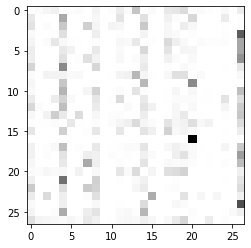

In [14]:
plt.imshow(bigram_freq_matrix, cmap='binary', interpolation='none')    

In [15]:
def starting_state():
    """
    Return a random permutation of indices representing the alphabet.
    """
    starting_ordering = list(range(0, 27))
    np.random.shuffle(starting_ordering)
    return starting_ordering

def sample_candidate(sample):
    """
    To search for new ciphers, create a 
    new cipher from the old cipher with
    two letters swapped.
    
    sample: previous cipher, list
    """
    to_swap = np.random.choice(27, 2)
    new_sample = sample[:]
    new_sample[to_swap[0]], new_sample[to_swap[1]] = sample[to_swap[1]], sample[to_swap[0]]
    return new_sample

def make_log_f(decode_string, transition_matrix):
    """
    Generates a function which computes the 
    log of the function f in the description 
    (the probability of observing the sequence 
    of characters in the message decoded by 
    cipher x), which is then used to calculate 
    acceptance probabilities.
    
    decode_string: secret message string
    transition_matrix: matrix representing
        transition probabilities from
        char i to char j.
    """
    def log_f(current_sample):
        sample_log_likelihood = 0
        for i in range(len(decode_string) - 1):
            first_char = ord(decode_string[i].upper()) - 65 if decode_string[i].isalpha() else 26
            second_char = ord(decode_string[i+1].upper()) - 65 if decode_string[i+1].isalpha() else 26

            s_first, s_second = current_sample[first_char], current_sample[second_char]
            sample_log_likelihood += np.log(transition_matrix[s_first][s_second])
        return sample_log_likelihood
    return log_f

def make_acceptance_scorer(decode_string, transition_matrix):
    """
    Calculate the acceptance probability, which is the
    probability of observing the message translated by
    the proposed cipher devided by the probability of
    observing the message translated by the current
    cipher. See notes above about using log likelihood
    for stability.
    
    decode_string: secret message string
    transition_matrix: matrix representing
        transition probabilities from
        char i to char j.
    """
    def scorer(current_sample, candidate):
        sample_log_likelihood = log_f(current_sample)
        candidate_log_likelihood = log_f(candidate)
        return np.exp(candidate_log_likelihood - sample_log_likelihood)
    return scorer

log_f = make_log_f(the_secret_message, bigram_freq_matrix)
scorer = make_acceptance_scorer(the_secret_message, bigram_freq_matrix)

In [19]:
samples = metropolis_hastings(sample_candidate, starting_state, scorer, 8000, step=100)

### Watch your Decoding Improve

We print out the first few samples below. As you continue to sample from the space of all ciphers, the quality of your decoding should improve roughly. You may have to run the algorithm a few times to achieve good results.

In [20]:
for sample in samples[::len(samples) // 5]:
    print(decode(the_secret_message, sample), '\n')

MZKGJYQTYXKBBKHQNMBBIYE UZ WYMZKJQTYE MXF TYQTYEKYSQGNTFYEF YZNGKUNEIYMGWYFME YEFKT YCFKYMU YWNRR U GEYMGWYQGNHQ YMTYNZSKTEKUTYNGTE MWYNYBNV YEF YAU MEFYKRYRU TFYMNUYEFNTYSUKAB ZYSUKPNW TYMTYMYG CYS UTS XENP YKGYW WQXENKGYEFMEYNTYGKEYU WYNTYTQTYU WYP GE WY EXYEFMEYFMTYA  GYWKZNGMENGJYEF YOKV TYKRYZIYS  UTYMGWYEF YPN CYKRYZIYR  WYI EYAIYEUINGJYEKYRKUX YEFNTYSUKAB ZYEKYXKGRKUZYEKYMZKJQTYIKQYIKQUT BRYMU YEUINGJYEKYXUQTFYKUNJNGMBNEIYMGWYQGNHQ G TTYMZKGJYQTYNTYMYJMZ YQBENZME BIYXKGPNGXNGJYQTYEKYXKGRKUZYEKYZ GNMBYBMAKUYMTYEMTVTYMGWYMXX SEYEF YW MBYKRYA NGJYOQTEYBNV YEF YU TEYKRYEF YXU CZME T 

TYSIN MO WSUUSZMLTUUG AREYRD TYSNMO ARTWCRO MO AS BMILOC ACR YLISELAG TID CTAR ACSOR KCS TER DLPPRERIA TID MILZMR TO LYBSOASEO LIOARTD L ULFR ACR HERTAC SP PEROC TLE ACLO BESHURY BESVLDRO TO T IRK BREOBRWALVR SI DRDMWALSI ACTA LO ISA ERD LO OMO ERD VRIARD RAW ACTA CTO HRRI DSYLITALIN ACR QSFRO SP YG BRREO TID ACR VLRK SP YG PRRD GRA HG AEGLIN AS PSEWR ACLO BESHURY AS WSIPSEY AS TYSNMO GSM GSMEORUP TER 

## Let's Get Sleuthy

What did Gary's secret message to Tavor say?

In [21]:
log_probs = [log_f(s) for s in samples]
best_cipher_index = np.argmax(log_probs)
print(decode(the_secret_message, samples[best_cipher_index]).upper())

TUSIG HE WSYYSZHLTYYN AROURD TUSGHE ARTWPRE HE AS CHILEP APR ULISOLAN TID PTAR APSER KPS TOR DLMMRORIA TID HILZHR TE LUCSEASOE LIEARTD L YLVR APR BORTAP SM MOREP TLO APLE COSBYRU COSFLDRE TE T IRK CROECRWALFR SI DRDHWALSI APTA LE ISA ORD LE EHE ORD FRIARD RAW APTA PTE BRRI DSULITALIG APR XSVRE SM UN CRROE TID APR FLRK SM UN MRRD NRA BN AONLIG AS MSOWR APLE COSBYRU AS WSIMSOU AS TUSGHE NSH NSHOERYM TOR AONLIG AS WOHEP SOLGLITYLAN TID HILZHRIREE TUSIG HE LE T GTUR HYALUTARYN WSIFLIWLIG HE AS WSIMSOU AS URILTY YTBSO TE ATEVE TID TWWRCA APR DRTY SM BRLIG XHEA YLVR APR OREA SM APR WORKUTARE


### Do you recognize the message?

You may notice that sometimes when you run the algorithm, certain letters are not decoded correctly. For example, "crewmates" may be translated as "crexmates." In addition, the decoding may fail catastrophically, never yielding a intelligible message. Why might this be the case?

### *YOUR ANSWER HERE* 

In the English language, certain characters have much higher frequencies than others. In the case of this message, the letter 'W' shows up only a few times. As a consequence, the probability of the sequence if the letter 'W' were to instead be mapped to another letter like 'X' may not be too different from the probability of the correct sequence, making the two ciphers difficult to distinguish.

Regarding the second part, when cipher is of low quality, any swap which is good in the long run wouldn't necessarily change overall the performance that much because the rest of the cipher is bad anyway. Thus, if the process never gets the jump start needed to get going, then it can stay stuck with a poor cipher for a long time.

[1] https://people.eecs.berkeley.edu/~sinclair/cs294/n1.pdf

[2] http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf

[3] http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf